# Experiments 1 : Two Moons 

## Variational Dense Layers

## LeNet-300-100 (MLP)

This is a quick demo for experiments done in Section 4.1. 

As per Molchanov(2017):

"Training our model from a random initialization is troublesome, as a lot of weights become pruned away early during training, before they could possibly learn a useful representation of the data. In this case we obtain a higher sparsity level, but also a high accuracy drop. The same problem is reported by (Sønderby et al., 2016) and is a common problem for Bayesian DNNs. One way to resolve this problem
is to start from a pre-trained network. This trick provides a fair sparsity level with almost no drop of accuracy. Here by pre-training we mean training of the original architecture without Sparse Variational Dropout until full convergence."

The aim of this demo is to demonstrate

- How to set up Bayesian/Frequentist pre-training strategies
- How to draw uncertainty from learned model
- How to use the utility functions in `MCUtils.jl` to make predictions, and compute uncertainties



# 0. Setup

## Packages

In [1]:
repo_root = normpath(@__DIR__, "..") # just repo path
include(joinpath(repo_root, "VariationalMLP", "src", "VariationalMLP.jl"))

using .VariationalMLP

In [2]:
include(joinpath(repo_root, "VariationalMLP", "src", "MCUtils.jl"))
using .MCUtils

In [3]:
using Flux, Statistics
using Flux: onehotbatch, onecold, Adam
using Flux.Losses: logitcrossentropy
#using Optimisers
using Zygote
using MLDatasets
using Plots


using MLJBase
using Random
#using Plots
using MLUtils: splitobs

# sampling
using StatsBase
using CSV, DataFrames
using CategoricalArrays

## Data

In [4]:
begin
	nobs_moon = 1000
	X_moon, y_moon = MLJBase.make_moons(nobs_moon)
	# Matrix(X_moon)
	X_moon = matrix(X_moon)
	y_moon = Array(y_moon)
end;

In [5]:
function split_train_test(X, y, ntrain)
    """
    Splits given dats into training and test data.

    Args

    X, y : data
    ntrain : number of training samples
    """

    Random.seed!(1308)
    idx = shuffle(1:size(X, 1))  # shuffle row indices

    xtrain = X[idx[1:ntrain], :]
    ytrain = y[idx[1:ntrain]]

    xtest = X[idx[ntrain+1:end], :]
    ytest = y[idx[ntrain+1:end]]

    return xtrain, ytrain, xtest, ytest

end

split_train_test (generic function with 1 method)

In [6]:
X_train, y_train, X_test, y_test = split_train_test(X_moon, y_moon, 50) # only 50 training data

([0.9910100091056948 -0.9312709980083215; 0.4888368080842904 -0.49295339938728877; … ; 0.16958129599844893 1.104171832412329; -0.9323240583415474 0.22347244286144274], [1, 1, 0, 1, 0, 1, 1, 0, 0, 1  …  1, 0, 1, 0, 1, 1, 1, 0, 0, 0], [-0.2524714352278464 1.0692284350772132; 0.3273857459274505 -0.2623611239953558; … ; 0.8272831198014634 -0.7932339226681165; 0.8676172393030893 0.6395767883542355], [0, 1, 1, 0, 0, 1, 0, 0, 0, 1  …  1, 1, 0, 1, 1, 0, 0, 1, 1, 0])

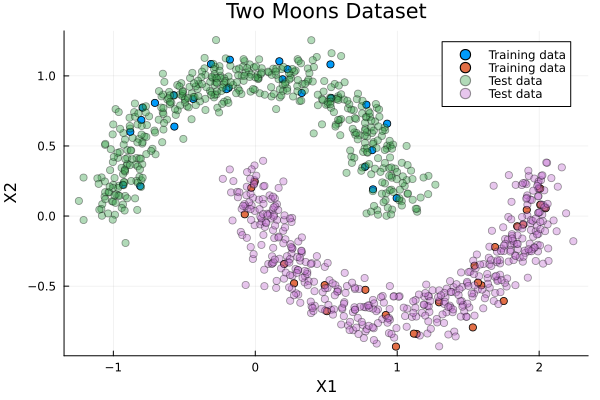

In [7]:
begin
	fig = scatter(X_train[:, 1], X_train[:, 2], group = y_train, legend = true, label = "Training data", title = "Two Moons Dataset", xlabel = "X1", ylabel = "X2")
	scatter!(X_test[:, 1], X_test[:, 2], group = y_test, legend = true, label = "Test data", alpha = 0.4)
end

In [8]:
# We must reshape them as each feature (column) is a data point
X_train = permutedims(X_train)
X_test = permutedims(X_test)

## one-hot encoded values for the labels
labels = [0, 1]
y_train = onehotbatch(y_train, labels)
y_test = onehotbatch(y_test, labels)

N = size(X_train, 2)
println("Size of training data : $N")

Size of training data : 50


In [9]:
batchsize = 1
data_loader = Flux.DataLoader((X_train, y_train), batchsize=batchsize, shuffle=true)

50-element DataLoader(::Tuple{Matrix{Float64}, OneHotArrays.OneHotMatrix{UInt32, Vector{UInt32}}}, shuffle=true)
  with first element:
  (2×1 Matrix{Float64}, 2×1 OneHotMatrix(::Vector{UInt32}) with eltype Bool,)

## Plots results

In [10]:
function plot_loss_sparsity(losses, sparsity_log; filename ="training.png")

    epochs = 1:length(losses)

    # Create the loss plot
    p1 = plot(epochs, losses,
        label = "Loss",
        marker = (:circle, 3),
        line = :solid,
        lw = 2,
        color = :blue,
        xlabel = "Epoch",
        ylabel = "F",
        title = "Variational Energy"
    )

    # Get sparisities for layers 
    layer1 = [s[1] for s in sparsity_log]
    layer2 = [s[2] for s in sparsity_log]
    layer3 = [s[3] for s in sparsity_log]




    # Create the sparsity plot
    p2 = plot(epochs, layer1,
        label = "Input Layer",
        marker = (:utriangle, 3),
        line = :dot,
        lw = 2,
        color = :red,
        xlabel = "Epoch",
        ylabel = "Sparsity",
        title = "Layer Sparsities"
    )

    plot!(p2, epochs, layer2,
        label = "Hidden Layer",
        marker = (:utriangle, 3),
        line = :dot,
        lw = 2,
        color = :orange
    )

    plot!(p2, epochs, layer3,
        label = "Output layer",
        marker = (:utriangle, 3),
        line = :dot,
        lw = 2,
        color = :yellow
    )



    # Combine side by side
    fig = plot(p1, p2, layout = (1, 2), size = (1000, 600))
    savefig(fig, filename)
    display(fig)
    println("Plot saved as $(filename)")


end
    

plot_loss_sparsity (generic function with 1 method)

## Training Loop(Bayesian)

In [11]:
function train_bayesian_model(model, data_loader;
                              N::Int,
                              total_epochs::Int = 50,
                              KLoff_epochs::Int = 10,
                              max_kl_scale::Float32 = 1.0f0,
                              task_type::Symbol = :classification,
                              η::Float32 = 1f-3,
                              enable_warmup::Bool = true,
                              verbose::Bool = true)

    # Setup optimizer
    opt = Flux.setup(Adam(η), model)

    # Storage
    losses = Float32[]
    sparsity_log = []

    for epoch in 1:total_epochs
        epoch_loss = 0.0f0

        if enable_warmup
            # linear warm up
            # KLoff allows user to decide for how many epochs they want to completely cut-off the KL before warming up
            kl_scale = epoch <= KLoff_epochs ? 0.0f0 : max_kl_scale * Float32((epoch - KLoff_epochs) / (total_epochs - KLoff_epochs))
        else

            #no warm up; KL divergence is introduced all at once
            kl_scale = 1.0f0
        end

         for (x, y) in data_loader
            loss, grads = Flux.withgradient(model) do m
                energy_loss(m, x, y, N; kl_scale=kl_scale,
                                        enable_warmup=enable_warmup,
                                        task_type=task_type)
            end
            Flux.update!(opt, model, grads[1])
            epoch_loss += loss
        end

        # Save metrics
        push!(losses, epoch_loss)
        sparsities = model_sparsity(model; custom_threshold=0.83) # for Graves
        push!(sparsity_log, sparsities)

        if verbose
            println("Epoch $epoch | Loss = $(round(epoch_loss, digits=4)) | Sparsities: ", round.(sparsities, digits=3))
        end
    end

    return (losses=losses, sparsity_log=sparsity_log, model=model, opt = opt)

end 

train_bayesian_model (generic function with 1 method)

## Zero counting -- for pruning

In [12]:
function check_zeroes(pruned_model)


    for (i, layer) in enumerate(pruned_model.layers)
        if hasproperty(layer, :θ)
            n_zeros = count(==(0f0), layer.θ)
            println("Layer $i (θ): $n_zeros zeroed elements")
        elseif hasproperty(layer, :μ)
            n_zeros = count(==(0f0), layer.μ)
            println("Layer $i (μ): $n_zeros zeroed elements")
        elseif hasproperty(layer, :μi)
            n_zeros = count(==(0f0), layer.μi)
            println("Layer $i (μi): $n_zeros zeroed elements")
        end
    end

end 

check_zeroes (generic function with 1 method)

# 1. Frequentist pre-training

I will first pre-train the LeNet-300-100 in the Frequentist approach

In [13]:

# Le-Net-300-100 but adapted for the same architecture
simple_ln31 = Chain(
    Dense(2, 300, relu), # hidden layer 1
    Dense(300, 100, relu), # hidden layer 2
    Dense(100, 2)
)


# Loss and accuracy
loss_function(x, y) = logitcrossentropy(simple_ln31(x), y)

function test_accuracy(x, y)
    ŷ = simple_ln31(x)
    pred = onecold(ŷ)
    true_classes = onecold(y)
    return mean(pred .== true_classes)
end

# Optimizer
opt = Adam(1f-3)

# Tracking metrics
epochs = 50
train_losses = Float32[]
test_accuracies = Float32[]

# Manual training loop
for epoch in 1:epochs
    for (x, y) in data_loader
        gs = gradient(() -> loss_function(x, y), Flux.params(simple_ln31))
        Flux.Optimise.update!(opt, Flux.params(simple_ln31), gs)
    end

    train_loss = loss_function(X_train, y_train)
    test_acc = test_accuracy(X_test, y_test)

    push!(train_losses, train_loss)
    push!(test_accuracies, test_acc)

    println("Epoch $epoch: train loss = $(round(train_loss, digits=4)), test accuracy = $(round(test_acc * 100, digits=2))%")
end

final_test_acc = test_accuracy(X_train, y_train)
println("Accuracy test set : $final_test_acc")


┌ Warning: Layer with Float32 parameters got Float64 input.
│   The input will be converted, but any earlier layers may be very slow.
│   layer = Dense(2 => 300, relu)
│   summary(x) = 2×1 Matrix{Float64}
└ @ Flux /Users/andreibleahu/.julia/packages/Flux/vwk6M/src/layers/stateless.jl:59


Epoch 1: train loss = 0.2438, test accuracy = 89.37%
Epoch 2: train loss = 0.1622, test accuracy = 90.63%
Epoch 3: train loss = 0.1514, test accuracy = 91.16%
Epoch 4: train loss = 0.1179, test accuracy = 93.16%
Epoch 5: train loss = 0.1056, test accuracy = 93.47%
Epoch 6: train loss = 0.0981, test accuracy = 94.0%
Epoch 7: train loss = 0.0946, test accuracy = 94.74%
Epoch 8: train loss = 0.0745, test accuracy = 95.16%
Epoch 9: train loss = 0.1011, test accuracy = 94.84%
Epoch 10: train loss = 0.049, test accuracy = 95.68%
Epoch 11: train loss = 0.0388, test accuracy = 96.42%
Epoch 12: train loss = 0.048, test accuracy = 96.63%
Epoch 13: train loss = 0.0257, test accuracy = 97.37%
Epoch 14: train loss = 0.0287, test accuracy = 97.68%
Epoch 15: train loss = 0.0185, test accuracy = 96.84%
Epoch 16: train loss = 0.0212, test accuracy = 97.79%
Epoch 17: train loss = 0.0132, test accuracy = 98.11%
Epoch 18: train loss = 0.0187, test accuracy = 97.79%
Epoch 19: train loss = 0.0101, test accu

In [14]:
losses_ln31wd = copy(train_losses)

50-element Vector{Float32}:
 0.24377385
 0.16220215
 0.15139414
 0.11792446
 0.10564414
 0.09809965
 0.094645
 0.07445108
 0.10108768
 0.04896956
 ⋮
 0.0007569008
 0.0007038332
 0.0006538215
 0.0006125873
 0.0005773469
 0.0005535078
 0.0005664434
 0.00048096236
 0.00048817493

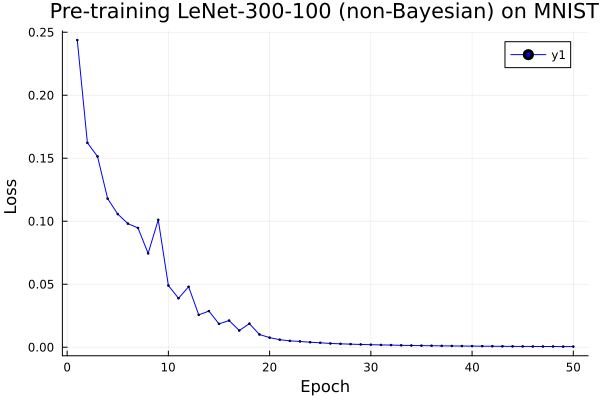

In [15]:
epochs = 1:length(train_losses)

plot(epochs, losses_ln31wd;
    marker = (:circle, 1),
    color = :blue,
    xlabel = "Epoch",
    ylabel = "Loss ",
    title = "Pre-training LeNet-300-100 (non-Bayesian) on MNIST")


Now, I will extract the weights and biases. Notice that we have trained this network until full convergence.

In [16]:
W1, b1 = simple_ln31[1].weight, simple_ln31[1].bias
W2, b2 = simple_ln31[2].weight, simple_ln31[2].bias
W3, b3 = simple_ln31[3].weight, simple_ln31[3].bias

(Float32[-0.006942663 0.22139457 … 0.07731962 0.02885834; 0.2043848 -0.10911291 … 0.18172435 -0.35284713], Float32[-0.017270878, 0.017270887])

We can now use these weights to pre-train networks.

Let's now create the same model, with the pre-trained weights, with the frequentist approach. We enable the "warm-up" meaning the KL divergence term is introduced gradually, rather than optimising the full variational objective. 

In [17]:
# Two layers LeNet-300-100
model_mol_pretrain = make_model([2, 300, 100, 2];  
                    activations =[relu, relu],
                   final_activation=identity,
                   variant=:graves,
                   init=:custom,
                   pretrained_Ws = [W1, W2, W3],
                   pretrained_bs = [b1, b2, b3])
                   

VarChain{Vector{Main.VariationalMLP.AbstractVariationalLayer}}(Main.VariationalMLP.AbstractVariationalLayer[Main.VariationalMLP.VariationalDense{typeof(relu)}(Float32[-0.2108148 0.044694416; 0.14128983 -0.25339735; … ; -0.047875974 0.037176892; 0.00075656106 0.20382531], Float32[0.0 0.0; 0.0 0.0; … ; 0.0 0.0; 0.0 0.0], Float32[-0.015171007, -0.09118859, 0.035517883, 0.019934328, -0.015730528, -0.062637985, -0.036194947, -0.08905017, -0.001698887, -0.0071700634  …  0.009390787, 0.014097303, -0.008708234, 0.032823652, -0.059628934, -0.06558681, -0.016585628, -0.06523112, 0.19547611, 0.040153246], NNlib.relu), Main.VariationalMLP.VariationalDense{typeof(relu)}(Float32[-0.13960426 0.075127885 … -0.10820431 -0.060930938; 0.060351886 -0.060557205 … 0.10571204 -0.045424003; … ; -0.060058553 0.02429037 … -0.08698339 -0.10063729; 0.212347 -0.034235887 … 0.15810446 3.7686877f-5], Float32[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], Float32[-0.008770251, 0.0189

In [18]:
results_11 = train_bayesian_model(model_mol_pretrain, data_loader;
                               N=N,
                               total_epochs=650,
                               KLoff_epochs=0, # we introduce it from the first epoch
                               max_kl_scale=1.0f0,
                               task_type=:classification,
                               enable_warmup=:true, # gradually introducing the KL div
                               η=1f-1)

Epoch 1 | Loss = 704453.0956 | Sparsities: [0.78, 0.926, 0.91]
Epoch 2 | Loss = 752211.6216 | Sparsities: [0.623, 0.855, 0.78]
Epoch 3 | Loss = 172382.5958 | Sparsities: [0.588, 0.835, 0.745]
Epoch 4 | Loss = 349854.9702 | Sparsities: [0.557, 0.815, 0.69]
Epoch 5 | Loss = 305242.8222 | Sparsities: [0.473, 0.778, 0.645]
Epoch 6 | Loss = 720486.7122 | Sparsities: [0.45, 0.769, 0.59]
Epoch 7 | Loss = 2.1291823539e6 | Sparsities: [0.377, 0.741, 0.595]
Epoch 8 | Loss = 1.2736148019e6 | Sparsities: [0.365, 0.727, 0.62]
Epoch 9 | Loss = 1.5993237941e6 | Sparsities: [0.363, 0.715, 0.545]
Epoch 10 | Loss = 1.4050705843e6 | Sparsities: [0.345, 0.705, 0.555]
Epoch 11 | Loss = 5.4029921966e6 | Sparsities: [0.308, 0.679, 0.495]
Epoch 12 | Loss = 6.0638641843e6 | Sparsities: [0.29, 0.663, 0.465]
Epoch 13 | Loss = 1.01445851917e7 | Sparsities: [0.273, 0.646, 0.44]
Epoch 14 | Loss = 2.23887003618e7 | Sparsities: [0.258, 0.618, 0.465]
Epoch 15 | Loss = 8.5181172687e7 | Sparsities: [0.255, 0.587, 0.385]

(losses = Float32[704453.1, 752211.6, 172382.6, 349854.97, 305242.8, 720486.7, 2.1291822f6, 1.2736148f6, 1.5993238f6, 1.4050706f6  …  1.6619142f11, 3.5351593f10, 3.8769885f10, 2.002909f10, 1.0451325f11, 2.6844682f10, 1.8354782f10, 1.6287544f10, 1.5716106f10, 1.5150068f10],
 sparsity_log = Any[[0.78, 0.9264666666666667, 0.91], [0.6233333333333333, 0.8553, 0.78], [0.5883333333333334, 0.8354333333333334, 0.745], [0.5566666666666666, 0.8149333333333333, 0.69], [0.47333333333333333, 0.7784666666666666, 0.645], [0.45, 0.7694333333333333, 0.59], [0.37666666666666665, 0.7413, 0.595], [0.365, 0.7268333333333333, 0.62], [0.36333333333333334, 0.7149666666666666, 0.545], [0.345, 0.7048333333333333, 0.555]  …  [0.25833333333333336, 0.36646666666666666, 0.065], [0.255, 0.36633333333333334, 0.055], [0.25333333333333335, 0.3666, 0.05], [0.25333333333333335, 0.3668, 0.05], [0.24833333333333332, 0.3654, 0.05], [0.24833333333333332, 0.3650333333333333, 0.05], [0.24666666666666667, 0.36516666666666664, 0.

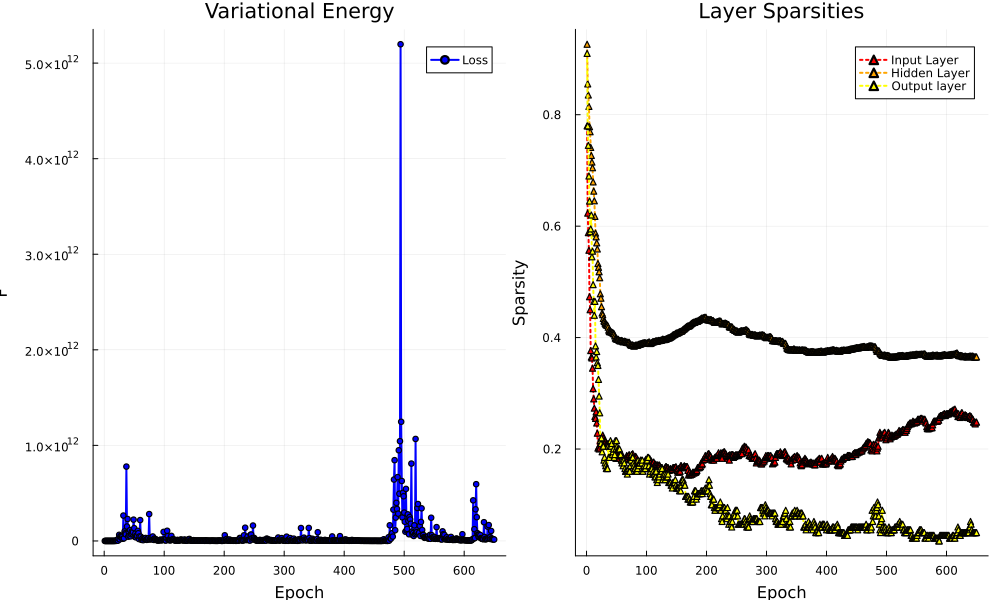

Plot saved as pretrain_frequentist_graves.png


In [19]:
plot_loss_sparsity(results_11.losses, results_11.sparsity_log; filename ="pretrain_frequentist_graves.png")

In [20]:
model_mol_pretrain = results_11.model

VarChain{Vector{Main.VariationalMLP.AbstractVariationalLayer}}(Main.VariationalMLP.AbstractVariationalLayer[Main.VariationalMLP.VariationalDense{typeof(relu)}(Float32[1.344f-42 -2.48f-42; 15.861359 -55.492645; … ; 13.120385 36.500828; -30.915188 10.728977], Float32[1.3862934 1.3862944; -0.8755117 -1.2149044; … ; -11.204341 6.7505155; -7.5524797 -4.8141265], Float32[-7.4598465, -4.7872906, 0.45404887, -8.37786, -5.318086, -0.14648429, -21.07529, -10.687757, -12.140605, -7.9043083  …  -7.9266396, -9.363155, -19.101433, 6.12819, -10.270136, -14.756172, -6.526184, -10.643064, -6.840439, -8.344353], NNlib.relu), Main.VariationalMLP.VariationalDense{typeof(relu)}(Float32[-2.5110745f-9 -32.52991 … -7.4662743 19.836365; -7.108534f-10 -56.409058 … 41.555103 59.06653; … ; 1.798f-42 77.796196 … -66.52496 -37.815517; 2.1103574f-10 51.232754 … -23.67487 -26.20329], Float32[1.3862944 -7.233988 … -12.990771 8.703353; 1.3862944 -5.5443234 … -5.936128 -0.3980731; … ; 1.3862944 -2.2823644 … 8.585616 -2.

Average test error per sample: [3.042105197906494, 2.747368335723877, 2.8105263710021973, 2.778947353363037, 2.8000001907348633, 2.768421173095703, 2.778947353363037, 2.757894992828369, 2.726315498352051, 2.863157272338867, 2.7894740104675293, 2.8210525512695312, 2.715789794921875, 2.8105263710021973, 2.778947353363037, 2.789473533630371, 2.8315787315368652, 2.715789794921875, 2.8000001907348633, 2.726315975189209]
Standard deviations: [0.5022571682929993, 0.16790856420993805, 0.16494959592819214, 0.13314852118492126, 0.1505095362663269, 0.09986139088869095, 0.12355661392211914, 0.12939712405204773, 0.1442442089319229, 0.10871534794569016, 0.14252696931362152, 0.12939713895320892, 0.08303266018629074, 0.16494959592819214, 0.0887656882405281, 0.12405380606651306, 0.126023069024086, 0.12939707934856415, 0.11315449327230453, 0.0597521997988224]
Figure saved as Frequentist_pretraining_Graves_accuracy.png


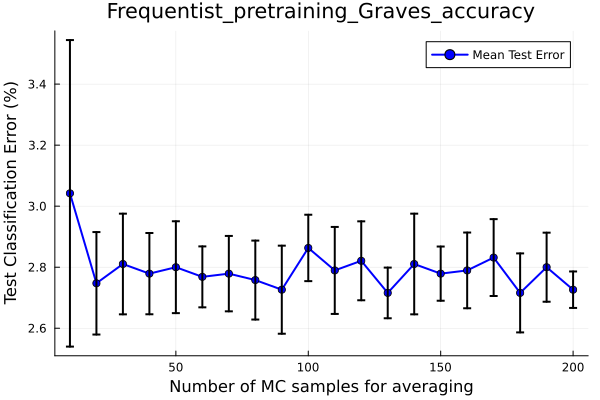

In [21]:
mc_experiments(10, 10, 10, 200, model_mol_pretrain, X_test, y_test, 2; filename ="Frequentist_pretraining_Graves_accuracy")

We can see the sparsity "per layer", for the final model.

In [22]:
for (i, layer) in enumerate(model_mol_pretrain.layers)
    println("Layer $i sparsity: ", round(layer_sparsity_calc_dense(layer)[1] * 100, digits=2), "%")
end

Layer 1 sparsity: 24.83%
Layer 2 sparsity: 36.53%
Layer 3 sparsity: 5.0%


Let's make copies for comparison

In [23]:
model_copy_principled = deepcopy(model_mol_pretrain)
model_copy_random = deepcopy(model_mol_pretrain)

VarChain{Vector{Main.VariationalMLP.AbstractVariationalLayer}}(Main.VariationalMLP.AbstractVariationalLayer[Main.VariationalMLP.VariationalDense{typeof(relu)}(Float32[1.344f-42 -2.48f-42; 15.861359 -55.492645; … ; 13.120385 36.500828; -30.915188 10.728977], Float32[1.3862934 1.3862944; -0.8755117 -1.2149044; … ; -11.204341 6.7505155; -7.5524797 -4.8141265], Float32[-7.4598465, -4.7872906, 0.45404887, -8.37786, -5.318086, -0.14648429, -21.07529, -10.687757, -12.140605, -7.9043083  …  -7.9266396, -9.363155, -19.101433, 6.12819, -10.270136, -14.756172, -6.526184, -10.643064, -6.840439, -8.344353], NNlib.relu), Main.VariationalMLP.VariationalDense{typeof(relu)}(Float32[-2.5110745f-9 -32.52991 … -7.4662743 19.836365; -7.108534f-10 -56.409058 … 41.555103 59.06653; … ; 1.798f-42 77.796196 … -66.52496 -37.815517; 2.1103574f-10 51.232754 … -23.67487 -26.20329], Float32[1.3862944 -7.233988 … -12.990771 8.703353; 1.3862944 -5.5443234 … -5.936128 -0.3980731; … ; 1.3862944 -2.2823644 … 8.585616 -2.

In [24]:
for (i, layer) in enumerate(model_copy_principled.layers)
    println("Layer $i sparsity: ", round(layer_sparsity_calc_dense(layer)[1] * 100, digits=2), "%")
end

Layer 1 sparsity: 24.83%
Layer 2 sparsity: 36.53%
Layer 3 sparsity: 5.0%


Let's prune the copy.

In [25]:
prune_dense!(model_copy_principled)
random_prune!(model_copy_random)

In [26]:
for (i, layer) in enumerate(model_copy_principled.layers)
    println("Layer $i sparsity: ", round(layer_sparsity_calc_dense(layer)[1] * 100, digits=2), "%")
end

Layer 1 sparsity: 0.0%
Layer 2 sparsity: 0.0%
Layer 3 sparsity: 0.0%


In [27]:
check_zeroes(model_copy_principled)

Layer 1 (μi): 149 zeroed elements
Layer 2 (μi): 10960 zeroed elements
Layer 3 (μi): 10 zeroed elements


In [28]:
check_zeroes(model_copy_random)

Layer 1 (μi): 149 zeroed elements
Layer 2 (μi): 10962 zeroed elements
Layer 3 (μi): 10 zeroed elements


Observe: 

- I pruned the same percentage number of weights in two ways : principled, randomly

Let's see how well the pruned model works

In [29]:
acc_nonpruned, pred_nonprun = mc_sampling(200, model_mol_pretrain, X_test, y_test, 2)
println("Accuracy of non-pruned model : $acc_nonpruned")

Accuracy of non-pruned model : 0.9715789473684211


In [30]:
acc_prun, pred_prun = mc_sampling(200, model_copy_principled, X_test, y_test, 2)
println("Accuracy of principled pruned model : $acc_prun")

Accuracy of principled pruned model : 0.9578947368421052


In [31]:
acc_nonpruned, pred_nonprun = mc_sampling(200, model_copy_random, X_test, y_test, 2)
println("Accuracy of random pruned model : $acc_nonpruned")

Accuracy of random pruned model : 0.9705263157894737


Observe:



## 1.2 Bayesian pre-training + Annealing (from random init)

In [32]:
model2 = make_model([2, 300, 100, 2];  
                    activations =[relu, relu],
                   final_activation=identity,
                   variant=:graves,
                   init=:random)

VarChain{Vector{Main.VariationalMLP.AbstractVariationalLayer}}(Main.VariationalMLP.AbstractVariationalLayer[Main.VariationalMLP.VariationalDense{typeof(relu)}(Float32[-0.3116517 0.45852497; -0.12395655 -0.69362944; … ; -0.31994364 1.3988756; 0.42479303 -0.9847117], Float32[-1.2121148 0.07149691; 0.7467881 0.4539689; … ; -2.4517138 0.4401368; -0.7782672 -0.67547727], Float32[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], NNlib.relu), Main.VariationalMLP.VariationalDense{typeof(relu)}(Float32[-0.70302296 -0.8298937 … 0.82184076 -1.0999757; 0.19509935 -0.25579652 … -0.14352395 -0.98945117; … ; 0.9923214 0.61254203 … 0.50752324 -0.52679974; 1.3334992 1.0625792 … 2.5604868 0.7925836], Float32[-0.13756865 -0.17841724 … 1.1249334 -0.024935955; 1.5114974 0.8001706 … -0.9774669 -1.0667588; … ; 0.3187911 -0.081082284 … -1.4235142 -1.2364293; 0.28174415 0.31902003 … -0.5583637 2.1521282], Float32[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,

In [33]:
results_12 = train_bayesian_model(model2, data_loader;
                               N=N,
                               total_epochs=650,
                               KLoff_epochs=50, # no KL div for first 50 epoch
                               max_kl_scale=1.0f0,
                               task_type=:classification,
                               enable_warmup=:true,
                               η=1f-1)


Epoch 1 | Loss = 551088.4355 | Sparsities: [0.495, 0.551, 0.52]
Epoch 2 | Loss = 392027.3345 | Sparsities: [0.487, 0.542, 0.53]
Epoch 3 | Loss = 576853.7235 | Sparsities: [0.455, 0.534, 0.515]
Epoch 4 | Loss = 261593.0022 | Sparsities: [0.408, 0.518, 0.5]
Epoch 5 | Loss = 312972.7967 | Sparsities: [0.412, 0.51, 0.495]
Epoch 6 | Loss = 740492.778 | Sparsities: [0.378, 0.501, 0.455]
Epoch 7 | Loss = 535596.8956 | Sparsities: [0.357, 0.496, 0.48]
Epoch 8 | Loss = 390686.3389 | Sparsities: [0.338, 0.493, 0.46]
Epoch 9 | Loss = 1.2404556462e6 | Sparsities: [0.34, 0.483, 0.38]
Epoch 10 | Loss = 2.1883243383e6 | Sparsities: [0.322, 0.475, 0.405]
Epoch 11 | Loss = 2.1314634192e6 | Sparsities: [0.32, 0.467, 0.4]
Epoch 12 | Loss = 3.0601136579e6 | Sparsities: [0.317, 0.458, 0.355]
Epoch 13 | Loss = 1.606659708e6 | Sparsities: [0.313, 0.451, 0.36]
Epoch 14 | Loss = 1.50576407863e7 | Sparsities: [0.277, 0.438, 0.315]
Epoch 15 | Loss = 4.4236244536e6 | Sparsities: [0.24, 0.433, 0.3]
Epoch 16 | Loss

(losses = Float32[551088.44, 392027.34, 576853.75, 261593.0, 312972.78, 740492.75, 535596.9, 390686.34, 1.2404556f6, 2.1883242f6  …  2.5413128f9, 4.2471816f9, 3.1212255f9, 2.9469002f9, 2.7370452f9, 2.5809572f9, 2.8565614f9, 4.0667345f10, 2.5528664f10, 1.1749096f10],
 sparsity_log = Any[[0.495, 0.5508, 0.52], [0.4866666666666667, 0.5419333333333334, 0.53], [0.455, 0.5345, 0.515], [0.4083333333333333, 0.5175666666666666, 0.5], [0.4116666666666667, 0.5097, 0.495], [0.37833333333333335, 0.5011666666666666, 0.455], [0.3566666666666667, 0.4959, 0.48], [0.3383333333333333, 0.4931, 0.46], [0.34, 0.48306666666666664, 0.38], [0.32166666666666666, 0.475, 0.405]  …  [0.23, 0.38913333333333333, 0.075], [0.23166666666666666, 0.3891, 0.075], [0.22833333333333333, 0.39, 0.075], [0.22833333333333333, 0.39026666666666665, 0.075], [0.23166666666666666, 0.39053333333333334, 0.075], [0.235, 0.39076666666666665, 0.075], [0.235, 0.39066666666666666, 0.075], [0.23666666666666666, 0.391, 0.08], [0.231666666666

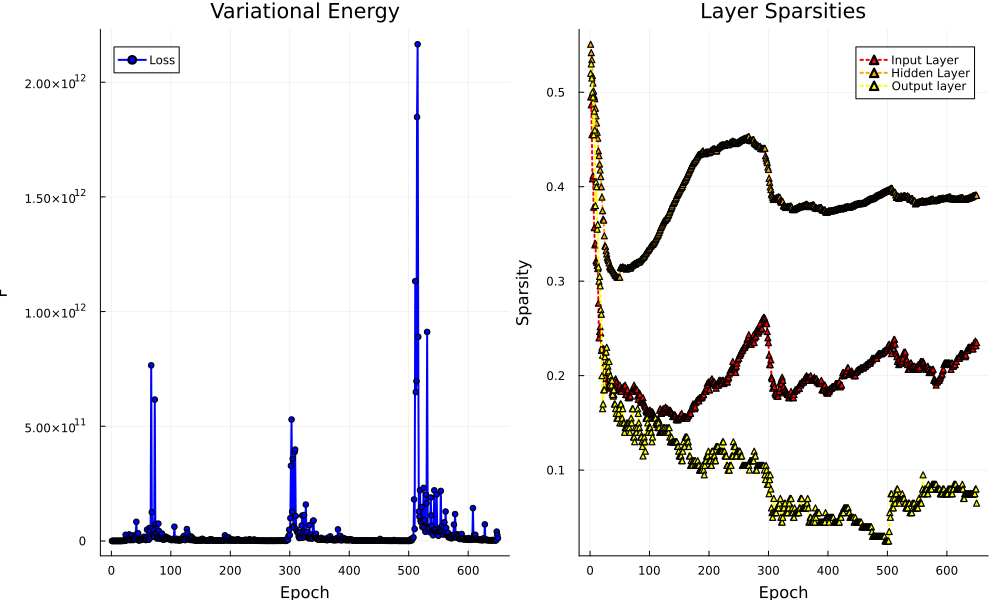

Plot saved as bayesian_pretrain_graves.png


In [34]:
plot_loss_sparsity(results_12.losses, results_12.sparsity_log; filename ="bayesian_pretrain_graves.png")

In [35]:
model2 = results_12.model

VarChain{Vector{Main.VariationalMLP.AbstractVariationalLayer}}(Main.VariationalMLP.AbstractVariationalLayer[Main.VariationalMLP.VariationalDense{typeof(relu)}(Float32[-7.783299 -6.6287813; 25.766382 -66.41268; … ; 19.211002 33.74726; -2.5066974 -0.6285445], Float32[1.132836 6.2869396; -19.609776 -7.2391143; … ; -13.309327 5.3851385; -0.021876499 1.4694273], Float32[-21.210526, -17.890333, 12.161149, 2.1151218, -17.280018, -12.254004, -4.910316, -13.16996, 1.5901772, -8.26401  …  -12.928858, -6.5597754, -8.308605, 13.794137, -12.065234, 3.9389625, -10.599443, 1.9735234, -11.318343, -7.0976048], NNlib.relu), Main.VariationalMLP.VariationalDense{typeof(relu)}(Float32[-15.480471 116.644844 … -2.7782567 -2.3826795; -15.839296 -40.823128 … 3.986578 1.970054f-8; … ; 21.024654 -88.788704 … 45.622314 2.0992687; -12.06204 78.439 … -26.791025 1.294616], Float32[-4.2768717 11.365015 … -7.7241087 4.1415234; -1.5069147 2.1951282 … -1.4367238 1.3862938; … ; -0.45988187 4.870286 … -4.0266714 1.4146122

Average test error per sample: [2.715789318084717, 2.726315975189209, 2.736842155456543, 2.6315789222717285, 2.6736843585968018, 2.705263137817383, 2.726315498352051, 2.6421055793762207, 2.6105263233184814, 2.6000001430511475, 2.5894737243652344, 2.726315975189209, 2.6736843585968018, 2.694736957550049, 2.6631579399108887, 2.5894737243652344, 2.6631581783294678, 2.6526312828063965, 2.6421051025390625, 2.6947367191314697, 2.6842105388641357, 2.6210525035858154, 2.747368335723877, 2.6315789222717285, 2.6631579399108887, 2.694736957550049, 2.694736957550049, 2.5684211254119873, 2.6736843585968018, 2.6000001430511475, 2.694736957550049, 2.6526317596435547, 2.684210777282715, 2.6210527420043945, 2.694736957550049, 2.6631579399108887, 2.6210527420043945, 2.715789318084717, 2.726315975189209, 2.6842105388641357, 2.694736957550049, 2.6315789222717285, 2.6526312828063965, 2.684210777282715, 2.715789318084717, 2.6631581783294678, 2.6315789222717285, 2.6526317596435547, 2.6421055793762207, 2.6631

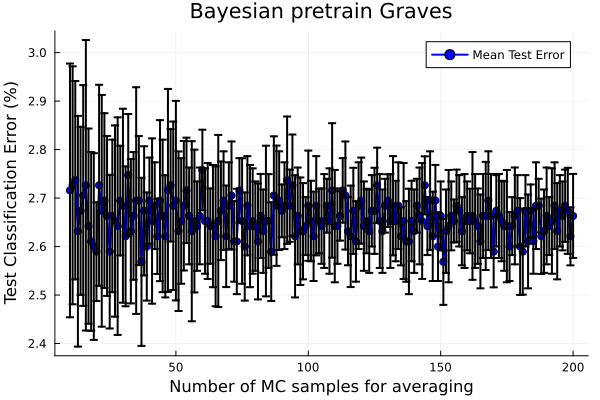

In [36]:
mc_experiments(10, 1, 10, 200, model2, X_test, y_test, 2; filename = "Bayesian pretrain Graves")

In [37]:
for (i, layer) in enumerate(model2.layers)
    println("Layer $i sparsity: ", round(layer_sparsity_calc_dense(layer)[1] * 100, digits=2), "%")
end

Layer 1 sparsity: 23.5%
Layer 2 sparsity: 39.07%
Layer 3 sparsity: 6.5%


In [38]:
model2_rand = deepcopy(model2)
model2_prin = deepcopy(model2)

VarChain{Vector{Main.VariationalMLP.AbstractVariationalLayer}}(Main.VariationalMLP.AbstractVariationalLayer[Main.VariationalMLP.VariationalDense{typeof(relu)}(Float32[-7.783299 -6.6287813; 25.766382 -66.41268; … ; 19.211002 33.74726; -2.5066974 -0.6285445], Float32[1.132836 6.2869396; -19.609776 -7.2391143; … ; -13.309327 5.3851385; -0.021876499 1.4694273], Float32[-21.210526, -17.890333, 12.161149, 2.1151218, -17.280018, -12.254004, -4.910316, -13.16996, 1.5901772, -8.26401  …  -12.928858, -6.5597754, -8.308605, 13.794137, -12.065234, 3.9389625, -10.599443, 1.9735234, -11.318343, -7.0976048], NNlib.relu), Main.VariationalMLP.VariationalDense{typeof(relu)}(Float32[-15.480471 116.644844 … -2.7782567 -2.3826795; -15.839296 -40.823128 … 3.986578 1.970054f-8; … ; 21.024654 -88.788704 … 45.622314 2.0992687; -12.06204 78.439 … -26.791025 1.294616], Float32[-4.2768717 11.365015 … -7.7241087 4.1415234; -1.5069147 2.1951282 … -1.4367238 1.3862938; … ; -0.45988187 4.870286 … -4.0266714 1.4146122

In [39]:
prune_dense!(model2_prin)
random_prune!(model2_rand)

In [40]:
acc_prun, pred_prun = mc_sampling(200, model2, X_test, y_test, 2)
println("Accuracy of non-pruned model : $acc_prun")

Accuracy of non-pruned model : 0.9747368421052631


In [41]:
acc_prun, pred_prun = mc_sampling(200, model2_prin, X_test, y_test, 2)
println("Accuracy of principled pruned model : $acc_prun")

Accuracy of principled pruned model : 0.9663157894736842


In [42]:
acc_nonpruned, pred_nonprun = mc_sampling(200, model2_rand, X_test, y_test, 2)
println("Accuracy of randomly pruned model : $acc_nonpruned")

Accuracy of randomly pruned model : 0.9473684210526315
